# Training of -layer NN with basic features
In this notebook, a vanilla 2-layer neural network is trained on all basic-engineered features.

- ReLU after the first liner layer
- Sigmoid after the second linear layer
- Batch Size: 64
- Hidden dim: 16
- Learning Rate: 0.1
- Num. of epochs: 100

We will save the models in "models/vanillann" of our Google Drive.


## 0. Imports and Constants
- Change the path in "cw_dir" to your local Google Drive sync location

In [2]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import json
from PIL import Image
import os
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
 ##################################################

############## TASK-SPECIFIC MODULES ##############
sys.path.append(os.path.join(os.getcwd(),"src"))
from vanilla_dataset import VanillaDataset, DataLoader
from vanilla_nn import VanillaNN
from evaluate import evaluate_model
from train import training_loop, plot_losses
from dataloader import custom_dataloader
###################################################


####################### CONSTANTS ########################
users = ["patriziopalmisano", "onurdenizguler", "jockl"]
SPLITS = ["train", "dev", "test"]
TRAIN, DEV, TEST, TXT, IMG = "train", "dev", "test", "txt", "img"
FE_METHODS = ["txt_embeddings", "img_embeddings", "concat", "sum", "mean", "hadamard"]
#FE_METHODS += ["concat_cos", "sum_cos", "mean_cos", "hadamard_cos"]
##########################################################

############## DATA SCIENCE & ML MODULES #################
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch
import pandas as pd
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import classification_report
##########################################################

####################### SELECT ###########################
user = users[0] # SELECT USER
version = "v2" # SELECT DATASET VERSION
dataset_version = version
##########################################################

if user in users[:2]:
    data_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_{version}"
    cw_dir = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/"

else:
    data_dir = f"/home/jockl/Insync/check.worthiness@gmail.com/Google Drive/data/CT23_1A_checkworthy_multimodal_english_{dataset_version}"
    cw_dir = "/home/jockl/Insync/check.worthiness@gmail.com/Google Drive"

features_dir = f"{data_dir}/features"
labels_dir = f"{data_dir}/labels"
models_dir = f"{cw_dir}/models/vanillannWithVal"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dictionary Keys
In this notebook, we will use dictionaries to reference corresponding data splits, feature engineering methods, labels, dataloaders etc. The following keys are used all the way:

In [3]:
# CONSTANT DICT KEYS -> MOVED TO IMPORTS!!!!
# SPLITS = ["train", "dev", "test"]
# FE_METHODS = ["concat", "concat_cos", "sum", "sum_cos", "mean", "mean_cos", "hadamard", "hadamard_cos"]

Note that the test split is not used in this notebook!

## 2. Load Training, Dev and Test Labels
First, we load the labels from the pickle files. We will later use them to set up our Dataloaders.

In [4]:
# Load training and dev labels from pickle file as np.array
split_to_labels = {split: np.load(f"{labels_dir}/{split}_labels_{dataset_version}.pickle", allow_pickle=True) for split in SPLITS}

Our label arrays have the following dimensions:

In [5]:
for split in SPLITS:
    print(f"{split} labels: {split_to_labels[split].shape} {split_to_labels[split][:10]}")

train labels: (2356,) [1 1 0 1 0 0 0 0 0 0]
dev labels: (271,) [0 0 0 1 1 0 0 0 1 1]
test labels: (548,) [0 1 0 0 1 0 0 0 0 0]


## 3. Load Engineered Features
Now, all engineered feature matrices for the train and dev split are loaded from their respective pickle files. We store them in a dictionary that maps split to feature method feature matrix.


In [6]:
# Load all engineered feature matrices for train and dev split
split_to_method_to_matrix = {split: {fe_method: np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}_{dataset_version}.pickle", allow_pickle=True) for fe_method in FE_METHODS} for split in SPLITS}

Those are the shapes of our feature matrices:

In [7]:
for split in SPLITS:
    for fe_method in FE_METHODS:
        print(f"{split}, {fe_method}: {split_to_method_to_matrix[split][fe_method].shape}")

train, txt_embeddings: (2356, 768)
train, img_embeddings: (2356, 768)
train, concat: (2356, 1536)
train, sum: (2356, 768)
train, mean: (2356, 768)
train, hadamard: (2356, 768)
dev, txt_embeddings: (271, 768)
dev, img_embeddings: (271, 768)
dev, concat: (271, 1536)
dev, sum: (271, 768)
dev, mean: (271, 768)
dev, hadamard: (271, 768)
test, txt_embeddings: (548, 768)
test, img_embeddings: (548, 768)
test, concat: (548, 1536)
test, sum: (548, 768)
test, mean: (548, 768)
test, hadamard: (548, 768)


# 3. Set up the PyTorch Datasets and Dataloaders
We set up a PyTorch Dataset and a Dataloader for every split and feature matrix loaded in the previous section. First, we define a batch size that every Dataloader uses. This batch size is constant throughout this notebook.

In [8]:
# Define hyperparameters
# Define batch size for all Dataloaders
batch_size = 16

Now, we instantiate our Datasets and Dataloaders.

In [9]:
# Instantiate VanillaDatasets
split_to_method_to_dataset = {split: {fe_method: VanillaDataset(split_to_method_to_matrix[split][fe_method], split_to_labels[split]) for fe_method in FE_METHODS} for split in SPLITS}

# Instantiate Dataloaders
split_to_method_to_dataloader = {split: {fe_method: DataLoader(split_to_method_to_dataset[split][fe_method], batch_size=batch_size) for fe_method in FE_METHODS} for split in SPLITS}

Let's have a look at the first batch from the dataloader of the train split, using the plainly concatenated features:

In [13]:
# Get example dataset/dataloader from the dictionaries
example_train_loader = split_to_method_to_dataloader["train"]["txt_embeddings"]
example_train_set = split_to_method_to_dataset["train"]["txt_embeddings"]

# Print info
print(f"No. of examples in the training set: {len(example_train_set[0][0])}")
for batch_no, batch in enumerate(example_train_loader):
    print(f"Batch No: {batch_no}\nfeatures in batch: {batch[0].shape}\nlabels in batch: {batch[1].shape}")
    break
print(len(example_train_set))
a = custom_dataloader(split_to_method_to_dataset['train']['txt_embeddings'], 'train', batch_size=16)
for batch_no, batch in enumerate(a):
    print(f"Batch No: {batch_no}\nfeatures in batch: {batch[0].shape}\nlabels in batch: {batch[1].shape}")
    break

No. of examples in the training set: 768
Batch No: 0
features in batch: torch.Size([16, 768])
labels in batch: torch.Size([16])
2356
Batch No: 0
features in batch: torch.Size([16, 768])
labels in batch: torch.Size([16])


# 5. Train and Save Models
In this section, we train a network for all feature engineering methods. The following parameters are used:

## 5.1 Train a model with unbalanced batches

In [14]:
device = torch.device('cpu')

In [15]:
# Train a model on the "text_embedding" features
# Get dataset and dataloader
fe_method = "txt_embeddings"
train_set = split_to_method_to_dataset["train"][fe_method]
train_dataloader = split_to_method_to_dataloader["train"][fe_method]
dev_set = split_to_method_to_dataset["dev"][fe_method]
dev_dataloader = split_to_method_to_dataloader["dev"][fe_method]
test_set = split_to_method_to_dataset["test"][fe_method]
test_dataloader = split_to_method_to_dataloader["test"][fe_method]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:05<00:00, 30.50it/s]


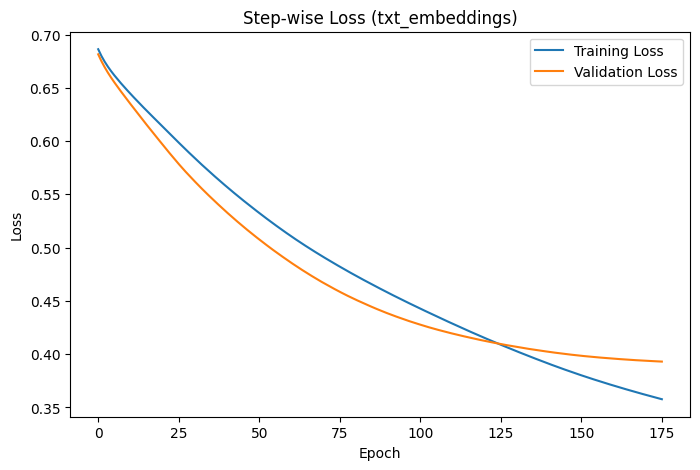

In [16]:
# Model Hyperparameters
input_dim = len(train_set[0][0])
output_dim = 1
layer_sizes = [input_dim, 64, 32, output_dim]
model = VanillaNN(layer_sizes)
model.to(device)
# Training Hyperparameters
loss_fn = torch.nn.BCELoss()
lr = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
num_epochs = 175

#Train the model
train_losses, val_losses = training_loop(device, train_dataloader, dev_dataloader, optimizer, model, loss_fn, num_epochs)

# Plot losses
plot_losses(num_epochs, train_losses, val_losses, fe_method)

In [17]:
# Compute basic metrics
print(f"\n{fe_method}\n")
model.to("cpu")
print(evaluate_model(model, test_dataloader))


txt_embeddings

              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       374
         1.0       0.73      0.71      0.72       174

    accuracy                           0.83       548
   macro avg       0.80      0.80      0.80       548
weighted avg       0.83      0.83      0.83       548



## 5.1 Train a model with balanced batches


In [18]:
# Train a model on the "text_embedding" features
# Get dataset and dataloader
fe_method = "txt_embeddings"
train_set = split_to_method_to_dataset["train"][fe_method]
train_dataloader = custom_dataloader(split_to_method_to_dataset['train'][fe_method], 'train', batch_size=batch_size)
dev_set = split_to_method_to_dataset["dev"][fe_method]
dev_dataloader = split_to_method_to_dataloader["dev"][fe_method]
test_set = split_to_method_to_dataset["test"][fe_method]
test_dataloader = split_to_method_to_dataloader["test"][fe_method]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:05<00:00, 30.33it/s]


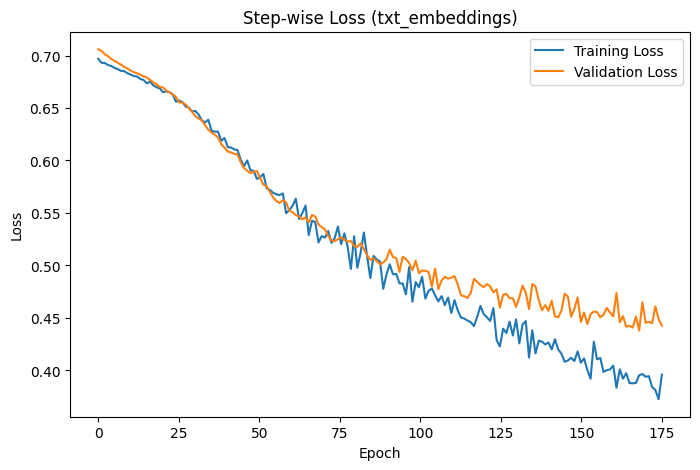

In [19]:
# Model Hyperparameters
input_dim = len(train_set[0][0])
output_dim = 1
layer_sizes = [input_dim, 64, 32, output_dim]
model = VanillaNN(layer_sizes)
model.to(device)
# Training Hyperparameters
loss_fn = torch.nn.BCELoss()
lr = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
num_epochs = 175

#Train the model
train_losses, val_losses = training_loop(device, train_dataloader, dev_dataloader, optimizer, model, loss_fn, num_epochs)

# Plot losses
plot_losses(num_epochs, train_losses, val_losses, fe_method)

# 7. Load Models and Evaluate
In this section, we load our trained models and compute basic metrics on the test data.

In [13]:
# Evaluate model for every feature engineering method
for fe_method in FE_METHODS:
   
    # Get dev dataset and dev dataloader
    test_set = split_to_method_to_dataset["test"][fe_method]
    test_dataloader = split_to_method_to_dataloader["test"][fe_method]

    # Instantiate the model
    input_dim = len(test_set[0][0])
    model = VanillaNN(input_dim, hidden_dim, output_dim)

    # Load the model 
    path = f"{models_dir}/{fe_method}_{dataset_version}.pt"
    model.load_state_dict(torch.load(path))
    model.eval()

    # Compute basic metrics
    print(f"\n{fe_method}\n")
    print(evaluate_model(model, test_dataloader))


concat

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81       374
         1.0       0.00      0.00      0.00       174

    accuracy                           0.68       548
   macro avg       0.34      0.50      0.41       548
weighted avg       0.47      0.68      0.55       548


concat_cos

              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85       374
         1.0       0.83      0.30      0.44       174

    accuracy                           0.76       548
   macro avg       0.79      0.63      0.64       548
weighted avg       0.77      0.76      0.72       548


sum

              precision    recall  f1-score   support

         0.0       0.74      0.96      0.83       374
         1.0       0.75      0.26      0.39       174

    accuracy                           0.74       548
   macro avg       0.75      0.61      0.61       548
weighted avg       0.74      0.74      0.69   

/Users/patriziopalmisano/miniforge3/envs/cw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patriziopalmisano/miniforge3/envs/cw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patriziopalmisano/miniforge3/envs/cw_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_